# Pedestrian Detection using RCNN

## Dataset Description

**Penn-Fudan Database for Pedestrian Detection**

---



This is an image database containing images that are used for pedestrian detection. The images are taken from scenes around campus and urban street. The objects we are interested in these images are pedestrians. Each image will have at least one pedestrian in it.

The heights of labeled pedestrians in this database fall into [180,390] pixels. All labeled pedestrians are straight up.

There are 170 images with 345 labeled pedestrians, among which 96 images are taken from around University of Pennsylvania, and other 74 are taken from around Fudan University.

**Directory structure:**

- PNGImages:   All the database images in PNG format.

- Annotation:  Annotation information for each image.  Each file is in the following format (take FudanPed00001.txt as an example):


In [2]:
import zipfile
import os
from google.colab import files

## Uploading PNGImages and Annotation

In [3]:
print("Select PNGImages.zip")
files.upload()
with zipfile.ZipFile('PNGImages.zip','r') as z: z.extractall('PNGImages')

Select PNGImages.zip


Saving PNGImages.zip to PNGImages (2).zip


In [4]:
print("Select Annotation.zip")
files.upload()
with zipfile.ZipFile('Annotation.zip','r') as z: z.extractall('Annotation')

Select Annotation.zip


Saving Annotation.zip to Annotation (1).zip


In [5]:
print("PNGImages/PNGImages sample:", os.listdir("PNGImages/PNGImages")[:5])
print("Annotation/Annotation sample:", os.listdir("Annotation/Annotation")[:5])

PNGImages/PNGImages sample: ['FudanPed00071.png', 'PennPed00034.png', 'PennPed00078.png', 'PennPed00087.png', 'PennPed00090.png']
Annotation/Annotation sample: ['PennPed00041.txt', 'PennPed00065.txt', 'FudanPed00037.txt', 'PennPed00054.txt', 'PennPed00002.txt']


# Actual code starts from here

In [6]:
!pip install torch torchvision

## Importing Libraries

In [7]:
import os, cv2, numpy as np, torch, torchvision
from PIL import Image
from torchvision import transforms as T
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.metrics import average_precision_score
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, Subset

In [8]:
import re

class PedestrianDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.img_folder = os.path.join(root, "PNGImages", "PNGImages")
        self.anno_folder = os.path.join(root, "Annotation", "Annotation")
        self.imgs = list(sorted(os.listdir(self.img_folder)))
        self.annos = list(sorted(os.listdir(self.anno_folder)))

        if transforms is None:
            self.transforms = T.Compose([T.ToTensor()])
        else:
            self.transforms = transforms

        self.pattern = re.compile(
            r'Bounding box.*\:\s+\((\d+),\s*(\d+)\)\s*-\s*\((\d+),\s*(\d+)\)'
        )

    def parse_annotation_file(self, anno_path):
        boxes = []
        with open(anno_path, 'r') as f:
            for line in f:
                match = self.pattern.search(line)
                if match:
                    xmin, ymin, xmax, ymax = map(int, match.groups())
                    boxes.append([xmin, ymin, xmax, ymax])
        return boxes

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.imgs[idx])
        anno_path = os.path.join(self.anno_folder, self.annos[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)

        boxes = self.parse_annotation_file(anno_path)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

PedestrianDataset class

This class:

- Loads images and their corresponding annotations from folders (PNGImages and Annotation).

- Extracts bounding box coordinates from each annotation XML file.

- Returns image tensors and target dictionaries for training.

## Dataset and DataLoader

In [9]:
from torch.utils.data import random_split, DataLoader, Subset

# Step 1: Create your full dataset instance
dataset = PedestrianDataset(root='.')

# Step 2: Filter dataset to keep only samples with bounding boxes
valid_indices = [i for i in range(len(dataset)) if dataset[i][1]['boxes'].shape[0] > 0]
valid_dataset = Subset(dataset, valid_indices)
print(f"Total valid samples with bounding boxes: {len(valid_dataset)}")

# Step 3: Split into 80% train and 20% test
total_valid = len(valid_dataset)
train_size = int(0.8 * total_valid)
test_size = total_valid - train_size
train_dataset, test_dataset = random_split(valid_dataset, [train_size, test_size])

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Step 4: Create DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Total valid samples with bounding boxes: 170
Train samples: 136, Test samples: 34


**What does collate_fn does?**

When you load data in batches, not all images have the same number of objects or bounding boxes.

The collate_fn function tells the DataLoader how to combine different samples into one batch without breaking that structure.

In simple terms:

- Normally, DataLoader stacks samples into one big tensor.

- But for object detection, each image can have a different number of boxes, so stacking doesn’t work.

- collate_fn instead groups them as lists — so your model can handle each image’s unique number of boxes correctly.

In [10]:
# dataset = PedestrianDataset(root='.', transforms=None)

# dataset.img_folder = 'PNGImages/PNGImages'
# dataset.anno_folder = 'Annotation/Annotation'
# dataset.imgs = list(sorted(os.listdir(dataset.img_folder)))
# dataset.annos = list(sorted(os.listdir(dataset.anno_folder)))

In [11]:
# print("Sample image path:", os.path.join(dataset.img_folder, dataset.imgs[0]))
# print("Sample annotation path:", os.path.join(dataset.anno_folder, dataset.annos[0]))

In [12]:
# print(f"Total images found: {len(dataset)}")
# print(f"Sample image files: {dataset.imgs[:5]}")
# print(f"Sample annotation files: {dataset.annos[:5]}")

In [13]:
# import torch
# from torch.utils.data import random_split

# total_size = len(dataset)
# train_size = int(0.7 * total_size)
# val_size = int(0.15 * total_size)
# test_size = total_size - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

In [14]:
# from torch.utils.data import DataLoader

# def collate_fn(batch):
#     return tuple(zip(*batch))

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

## Model Setup

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [16]:
# Load a pre-trained Faster RCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Modify the classifier for your task of pedestrian detection (1 class + background)
num_classes = 2  # pedestrian and background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

- Loads a Faster R-CNN model with a ResNet-50 backbone pretrained on the COCO dataset.
- Replace classification head for your task:
  - So now the model knows it only needs to classify:

      - 0 → background

      - 1 → pedestrian

In [18]:
device = torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Optimizer and Scheduler

In [19]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Training

In [21]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()
    lr_scheduler.step()

    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")

Epoch 1 Training Loss: 15.5128
Epoch 2 Training Loss: 8.0142
Epoch 3 Training Loss: 6.0594
Epoch 4 Training Loss: 4.4651
Epoch 5 Training Loss: 3.9010


## Testing

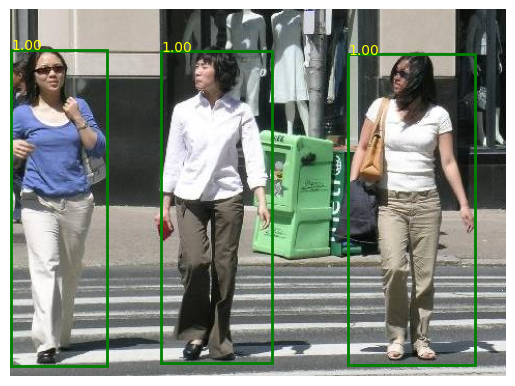

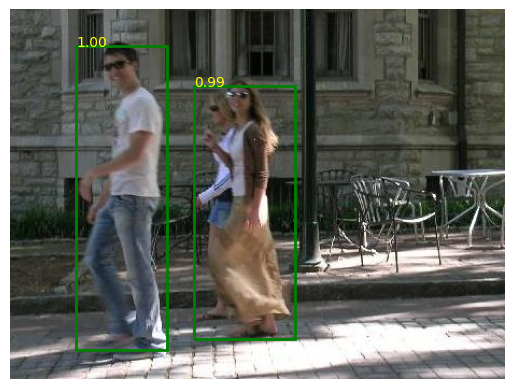

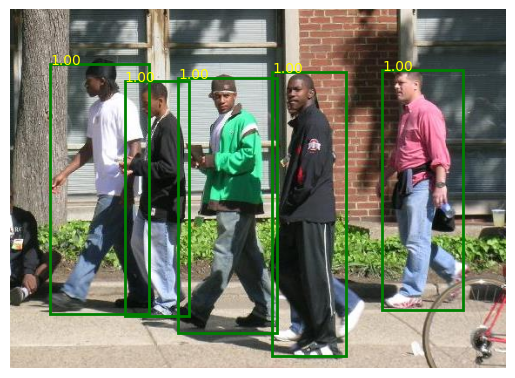

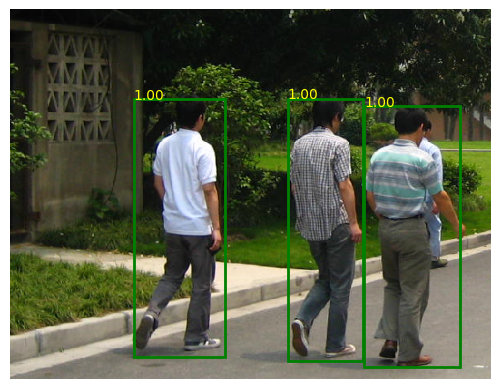

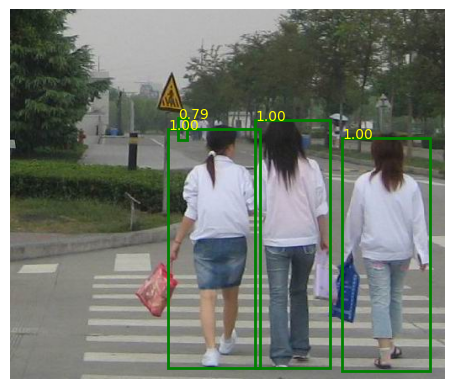

In [26]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_single_image(img_tensor, output, threshold=0.5):
    img = img_tensor.mul(255).permute(1,2,0).byte().cpu().numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.axis('off')  # Disable axis and grid lines
    boxes = output['boxes'].cpu()
    scores = output['scores'].cpu()
    for i, box in enumerate(boxes):
        if scores[i] < threshold:
            continue
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='green', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{scores[i]:.2f}", color='yellow')

    plt.show()

# Randomly pick 5 indices from test dataset
random_indices = random.sample(range(len(test_loader.dataset)), 5)

model.eval()
with torch.no_grad():
    for idx in random_indices:
        img, _ = test_loader.dataset[idx]
        prediction = model([img.to(device)])[0]
        visualize_single_image(img, prediction, threshold=0.7)